## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [41]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import shutil

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.gland import gland_data

%matplotlib inline 

# MODEL_PATH = os.path.join(ROOT_DIR, "./samples/mask_rcnn_gland_0030.h5")
# MODEL_DIR = MODEL_PATH
MODEL_PATH = '/home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet101/mask_rcnn_gland_0020.h5'
MODEL_DIR = MODEL_PATH

In [42]:
MODEL_PATH

'/home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet101/mask_rcnn_gland_0020.h5'

## Configurations

In [43]:
config = gland_data.GlandConfig()
config.display()
DATASET_DIR = '/home/mkubita/Pulpit/projektBadawczy/Dataset_Model/'


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [44]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.BACKBONE = "resnet50"
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [45]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [46]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [47]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = gland_data.GlandDataset()
dataset.load_gland(DATASET_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))



Image Count: 56
Class Count: 2
  0. BG                                                
  1. gland                                             


## Load Model

In [48]:
# Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                          config=config)

# Load weights
print("Loading weights ", MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)

P5 (None, None, None, 256)
Loading weights  /home/mkubita/Pulpit/projektBadawczy/Wyniki/Resnet101/mask_rcnn_gland_0020.h5


## Run Detection

55
image ID: gland.testA_60.bmp (55) /home/mkubita/Pulpit/projektBadawczy/Dataset_Model/val/testA_60.bmp
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
--------------------
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
scores                   shape: (5,)                  min:    0.91078  max:    0.97582  float32
masks                    shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool
gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (12, 4)               min:    0.00000  max:  857.00000  int32
gt_

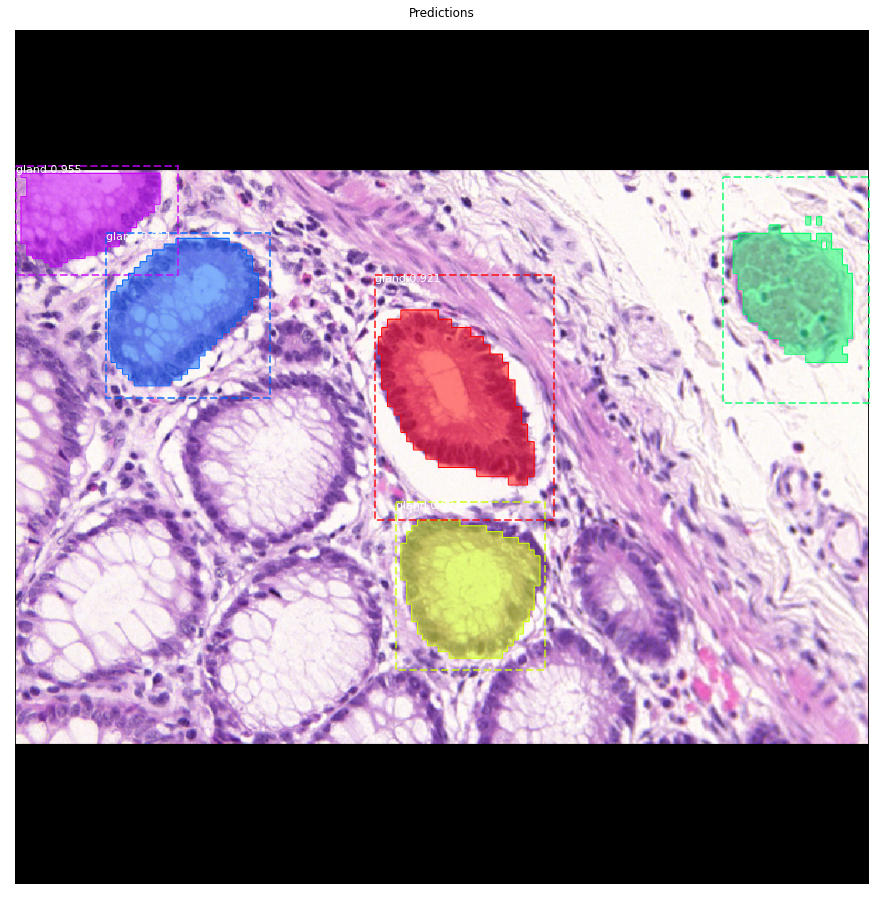

In [50]:
image_id = random.choice(dataset.image_ids)
print(image_id)
config.USE_MINI_MASK = False
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
print('--------------------')
log("class_ids", r["class_ids"])
log("scores", r["scores"])
log("masks", r["masks"])
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [10]:
image_id = random.choice(dataset.image_ids)

image = dataset.load_image(image_id)


### Precision-Recall

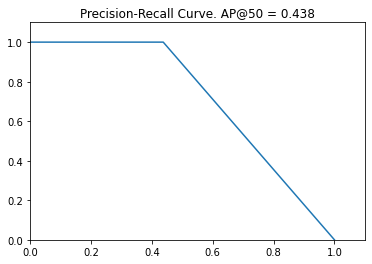

In [11]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])


visualize.plot_precision_recall(AP, precisions, recalls)


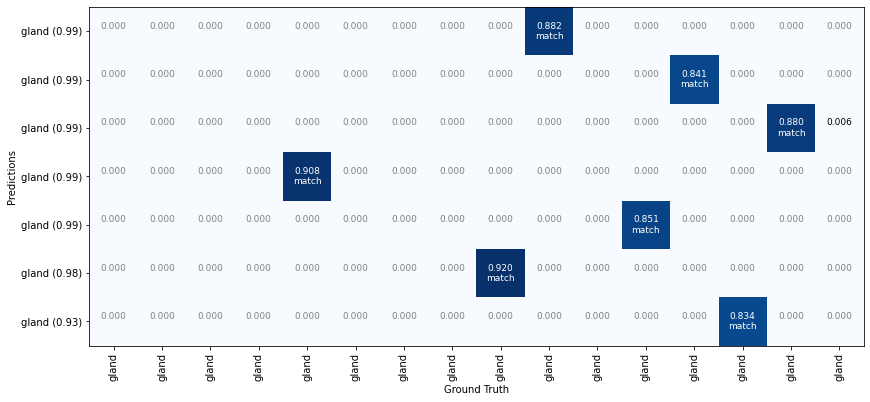

In [12]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [13]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
# image_ids = np.random.choice(dataset.image_ids, 20)
# for all test images
image_ids = dataset.image_ids
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.0954858787091715


In [107]:
from tensorflow.python.summary.summary_iterator import summary_iterator

In [109]:
import tensorflow

In [115]:
for summary in tensorflow.train.latest_checkpoint("/home/mkubita/Pulpit/projektBadawczy/Wyniki/Train_1/train/test.v2"):
    print(summary)

TypeError: 'NoneType' object is not iterable

In [68]:
# with open('/home/mkubita/Pulpit/projektBadawczy/Wyniki/Train_1/train/events.out.tfevents.1651780742.k-mkubita01.35668.10318.v2', 'rb') as file:
#     f = file.readlines()
# for line in f:
#     try:
#         print(line.decode(line, 'utf-8'))
#     except:
#         pass

In [117]:
print(dir(tensorflow.train))

['BytesList', 'Checkpoint', 'CheckpointManager', 'ClusterDef', 'ClusterSpec', 'Coordinator', 'Example', 'ExponentialMovingAverage', 'Feature', 'FeatureList', 'FeatureLists', 'Features', 'FloatList', 'Int64List', 'JobDef', 'SequenceExample', 'ServerDef', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'checkpoints_iterator', 'experimental', 'get_checkpoint_state', 'latest_checkpoint', 'list_variables', 'load_checkpoint', 'load_variable']


In [147]:
import tensorflow as tf
metrics = {}

for event in tf.compat.v1.train.summary_iterator('/home/mkubita/Pulpit/projektBadawczy/Wyniki/Train_1/train/test.v2'):
    if event.step not in metrics:
        metrics[event.step] = {}
    if len(event.summary.value) != 0:
        metrics[event.step][event.summary.value[0].tag] = event.summary.value[0].simple_value
    #     for value in event.summary.value:
#         print(value.tag)
#         if value.HasField('simple_value'):
#             print(value.simple_value)

In [149]:
epoch_loss = list()
epoch_rpn_class_loss = list()
epoch_rpn_bbox_loss = list()
epoch_mrcnn_class_loss = list()
epoch_mrcnn_bbox_loss = list()
epoch_mrcnn_mask_loss = list()

for step, value in metrics.items():
    epoch_loss.append(value['epoch_loss'])
    epoch_rpn_class_loss.append(value['epoch_rpn_class_loss'])
    epoch_rpn_bbox_loss.append(value['epoch_rpn_bbox_loss'])
    epoch_mrcnn_class_loss.append(value['epoch_mrcnn_class_loss'])
    epoch_mrcnn_bbox_loss.append(value['epoch_mrcnn_bbox_loss'])
    epoch_mrcnn_mask_loss.append(value['epoch_mrcnn_mask_loss'])

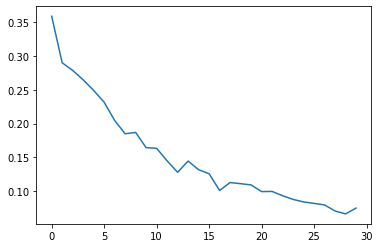

In [154]:
plt.plot(epoch_mrcnn_class_loss)
plt.show()

In [ ]:
# Train 1 - resnet101
# Train 2 -resnet50 + data augumentation